# Ensemble

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import sys
sys.path.insert(0, "../src")

In [15]:
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn import model_selection
from scipy.special import softmax

import torch
import torchcontrib
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

import callbacks
import config
import dataset
import engine
import models
import utils

import warnings
warnings.filterwarnings("ignore")

In [16]:
# df = pd.read_csv(config.DATA_PATH / "train.csv")
df = pd.read_csv(config.DATA_PATH / "pl-spinal-ensemble10.csv")
df.shape

(20058, 788)

In [17]:
nets = 10
device = torch.device(config.DEVICE)
EPOCHS = 200
SEED = 42
utils.seed_everything(SEED)

In [24]:
cnns = [None] * nets
valid_scores = []

for i in range(nets):
    print("#" * 30)
    # DATA
    train_indices, valid_indices = model_selection.train_test_split(np.arange(len(df)), test_size=0.1, shuffle=True, stratify=df.digit)
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.TEST_BATCH_SIZE)
    
    # MODEL
    model = models.SpinalVGG().to(device)
    
    # OPTIMIZER
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    # SCHEDULER
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', verbose=True, patience=10, factor=0.5,
    )
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # STOCHASTIC WEIGHT AVERAGING
    swa_start = int(EPOCHS * 0.75)
    swa_scheduler = SWALR(
        optimizer, anneal_strategy="cos", anneal_epochs=swa_start, swa_lr=5e-4
    )
    swa_model = AveragedModel(model)
    swa_model.to(device)

    # AMP
    scaler = torch.cuda.amp.GradScaler()
        
    # Loop
    for epoch in range(EPOCHS):
        # TRAIN ONE EPOCH
        engine.train(train_loader, model, optimizer, device, scaler)

        # VALIDATION
        predictions, targets = engine.evaluate(valid_loader, model, device)
        predictions = np.argmax(predictions, axis=1)
        accuracy = metrics.accuracy_score(targets, predictions)
        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy:.5f}")

        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step(accuracy)

    # Warmup BN-layers
    swa_model = swa_model.cpu()
    update_bn(train_loader, swa_model)
    swa_model.to(device)

    # CV Score for SWA model
    valid_preds, valid_targs = engine.evaluate(valid_loader, swa_model, device)
    valid_predsb = np.argmax(valid_preds, axis=1)
    
    valid_accuracy = metrics.accuracy_score(valid_targs, valid_predsb)
    valid_scores.append(valid_accuracy)
    print(f"CNN {i}, Validation accuracy of SWA model={valid_accuracy}")
    
    cnns[i] = swa_model

    # CLEAN-UP
    del model, swa_model
    torch.cuda.empty_cache()
    gc.collect()
    
    break

print(f"Average CV score={np.mean(valid_scores)}")

##############################
Epoch=0, Accuracy=0.69143
Epoch=10, Accuracy=0.93071
Epoch=20, Accuracy=0.94417
Epoch=30, Accuracy=0.93868
Epoch    37: reducing learning rate of group 0 to 5.0000e-03.
Epoch=40, Accuracy=0.95414
Epoch=50, Accuracy=0.94467
Epoch=60, Accuracy=0.94716
Epoch    62: reducing learning rate of group 0 to 2.5000e-03.
Epoch=70, Accuracy=0.94865
Epoch    78: reducing learning rate of group 0 to 1.2500e-03.
Epoch=80, Accuracy=0.95065
Epoch=90, Accuracy=0.94965
Epoch    94: reducing learning rate of group 0 to 6.2500e-04.
Epoch=100, Accuracy=0.95065
Epoch   110: reducing learning rate of group 0 to 3.1250e-04.
Epoch=110, Accuracy=0.95065
Epoch=120, Accuracy=0.94915
Epoch   126: reducing learning rate of group 0 to 1.5625e-04.
Epoch=130, Accuracy=0.95015
Epoch=140, Accuracy=0.94865
Epoch   142: reducing learning rate of group 0 to 7.8125e-05.
Epoch=150, Accuracy=0.94965
Epoch=160, Accuracy=0.95065
Epoch=170, Accuracy=0.94915
Epoch=180, Accuracy=0.95015
Epoch=190, Acc

## PL

In [30]:
df_test = pd.read_csv(config.TEST_CSV)
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE)

In [31]:
# BLENDED SOFTMAX OF MODELS
preds = np.zeros((len(df_test), 10))
for model in cnns:
    preds += engine.evaluate(test_loader, model, device, target=False)
probs = softmax(preds, axis=1)
probs = np.max(probs, axis=1)
digits = np.argmax(preds, axis=1)

In [32]:
pl = df_test.copy()
pl["digit"] = digits
pl["prob"] = probs
pl.head()

,id,letter,0,1,2,3,4,5,6,7,...,776,777,778,779,780,781,782,783,digit,prob
0,2049,L,0,4,0,2,4,2,3,1,...,4,2,2,4,3,4,1,4,6,1.0
1,2050,C,4,1,4,0,1,1,0,2,...,2,4,2,4,2,2,1,2,9,1.0
2,2051,S,0,4,0,1,3,2,3,0,...,2,0,3,2,3,0,1,4,8,1.0
3,2052,K,2,1,3,3,3,4,3,0,...,3,2,4,1,0,4,4,4,0,1.0
4,2053,W,1,0,1,1,2,2,1,4,...,1,4,0,2,1,2,3,4,3,1.0


In [35]:
pl = pl[pl.prob > 0.995]
print(f"{len(pl)}/{len(df_test)}")

20058/20480


In [36]:
pl.to_csv(config.DATA_PATH / f"pl-spinal-ensemble{nets}.csv", index=False)

## Inference

In [37]:
submission = pd.DataFrame({"id": df_test.id, "digit": digits})
submission.to_csv(f"../output/spinal-ensemble{nets}.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3


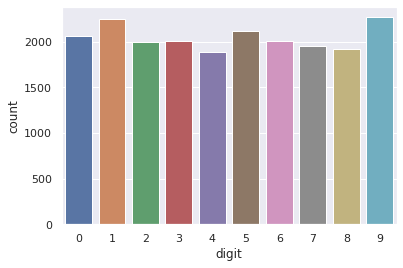

In [39]:
sns.countplot(submission.digit);